In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import vector
import boost_histogram as bh
import mplhep as hep

In [2]:
def histogram(data, bins, data_label, axes, density=True, ratio=True, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)


### Load data

In [3]:
def data_generator(input_file,channel):
    tree = uproot.open(f"{input_file}")
    tree_reco = tree['Reco;1']
    tree_tops = tree['Top;1']

    top_pt = tree_tops['pt'].array()
    top_eta = tree_tops['eta'].array()
    top_phi = tree_tops['phi'].array()
    top_energy = tree_tops['energy'].array()

    tops = vector.zip({'pt': top_pt, 'eta': top_eta, 'phi': top_phi, 'E': top_energy})

    reco_pt = tree_reco['pt'].array()
    reco_eta = tree_reco['eta'].array()
    reco_phi = tree_reco['phi'].array()
    reco_energy = tree_reco['energy'].array()

    jets = vector.zip({'pt': reco_pt,'eta': reco_eta, 'phi': reco_phi, 'energy': reco_energy})

    reco_indices = tree_reco['matching_indices'].array()
    
    pad_length = len(reco_indices[0])

    reco_pt_pad_none = ak.pad_none(reco_pt,pad_length)
    reco_pt_pad = ak.fill_none(reco_pt_pad_none,0)

    if channel == "3t":
        b_mask = (reco_indices > 0) & (reco_indices < 4)
        jet_mask = reco_indices > 3
    if channel == "4t":
        b_mask = (reco_indices > 0) & (reco_indices < 5)
        jet_mask = reco_indices > 4

    b_pt = ak.flatten(ak.mask(reco_pt_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_pt_pad,b_mask)))]

    reco_eta_pad_none = ak.pad_none(reco_eta,pad_length)
    reco_eta_pad = ak.fill_none(reco_eta_pad_none,0)
    b_eta = ak.flatten(ak.mask(reco_eta_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_eta_pad,b_mask)))]

    reco_phi_pad_none = ak.pad_none(reco_phi,pad_length)
    reco_phi_pad = ak.fill_none(reco_phi_pad_none,0)

    b_phi = ak.flatten(ak.mask(reco_phi_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_phi_pad,b_mask)))]

    reco_energy_pad_none = ak.pad_none(reco_energy,pad_length)
    reco_energy_pad = ak.fill_none(reco_energy_pad_none,0)
    b_energy = ak.flatten(ak.mask(reco_energy_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_energy_pad,b_mask)))]

    reco_pt_masked = ak.flatten(ak.mask(reco_pt_pad,jet_mask))
    reco_pt_non_none = reco_pt_masked[~ak.is_none(reco_pt_masked)]
    reco_pt_matched = ak.unflatten(reco_pt_non_none,2)

    reco_eta_masked = ak.flatten(ak.mask(reco_eta_pad,jet_mask))
    reco_eta_non_none = reco_eta_masked[~ak.is_none(reco_eta_masked)]
    reco_eta_matched = ak.unflatten(reco_eta_non_none,2)

    reco_phi_masked = ak.flatten(ak.mask(reco_phi_pad,jet_mask))
    reco_phi_non_none = reco_phi_masked[~ak.is_none(reco_phi_masked)]
    reco_phi_matched = ak.unflatten(reco_phi_non_none,2)

    reco_energy_masked = ak.flatten(ak.mask(reco_energy_pad,jet_mask))
    reco_energy_non_none = reco_energy_masked[~ak.is_none(reco_energy_masked)]
    reco_energy_matched = ak.unflatten(reco_energy_non_none,2)

    reco_matched = vector.zip({'pt': reco_pt_matched, 'eta': reco_eta_matched, 'phi': reco_phi_matched, 'E': reco_energy_matched})
    b_jet = vector.zip({'pt': b_pt, 'eta': b_eta, 'phi': b_phi, 'E': b_energy})

    return tops, jets, reco_matched, b_jet

# Run the function
tops_3t, jets_3t, not_b_jets_matched_3t, b_jet_3t = data_generator("../sm_3t_0L_14Feb.root","3t")
tops_4t, jets_4t, not_b_jets_matched_4t, b_jet_4t = data_generator("../sm_4t_0L_25Feb.root","4t")

matched_jets_3t = ak.concatenate((not_b_jets_matched_3t,ak.unflatten(b_jet_3t,1)),axis=1)
matched_jets_4t = ak.concatenate((not_b_jets_matched_4t,ak.unflatten(b_jet_4t,1)),axis=1)

### $\Delta R$

In [4]:
def delta_r_top_reco(jet, top):
    jet_1 = jet[:,0]
    jet_2 = jet[:,1]
    jet_3 = jet[:,2]

    delta_r_1 = jet_1.deltaR(top)
    delta_r_2 = jet_2.deltaR(top)
    delta_r_3 = jet_3.deltaR(top)
    delta_r = np.concatenate([delta_r_1, delta_r_2, delta_r_3],axis=1)
    return delta_r

delta_r_3t = delta_r_top_reco(jets_3t, tops_3t)
delta_r_4t = delta_r_top_reco(jets_4t, tops_4t)

### Centrality

In [5]:
def centrality(jets,b_jet):
    jet_1 = jets.rapidity[:,0]
    jet_2 = jets.rapidity[:,1]

    return np.abs((b_jet.rapidity - 0.5*(jet_1 + jet_2))/abs(jet_1 - jet_2))
centrality_3t = centrality(not_b_jets_matched_3t,b_jet_3t)
centrality_4t = centrality(not_b_jets_matched_4t,b_jet_4t)

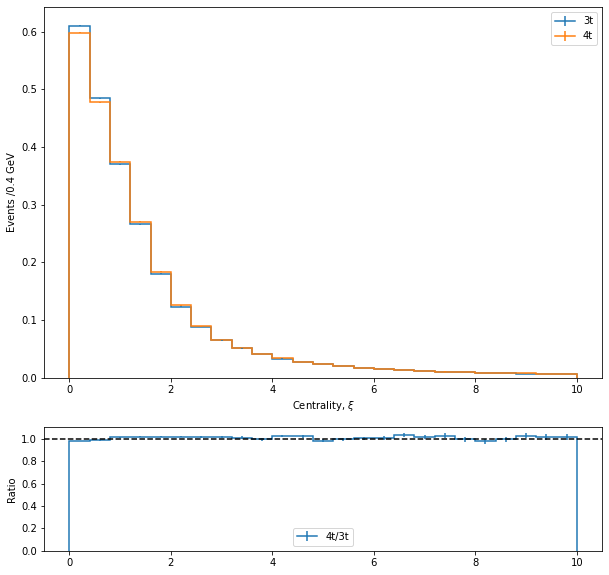

In [6]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([centrality_3t, centrality_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1], set_range=(0,10))
ax[0].set_xlabel(r'Centrality, $\xi$')
plt.show()

3191235


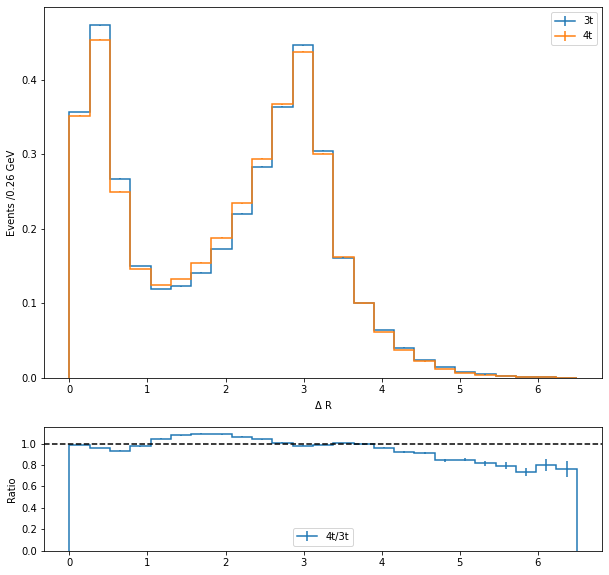

In [11]:
delta_r_3t_all = ak.flatten(delta_r_3t,axis=1)
print(len(delta_r_3t_all))
delta_r_4t_all = ak.flatten(delta_r_4t,axis=1)
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([ak.flatten(delta_r_3t), ak.flatten(delta_r_4t)], 25, ['3t','4t'], ax[0], ratio_axes=ax[1], set_range=(0,6.5))
ax[0].set_xlabel(r'$\Delta$ R')
plt.show()

### Invariant mass 

In [9]:
invariant_mass_jets_3t = np.sum(not_b_jets_matched_3t.M,axis=1)
invariant_mass_jets_4t = np.sum(not_b_jets_matched_4t.M,axis=1)

print(invariant_mass_jets_3t)
print(invariant_mass_jets_4t)

[30.4, 28.3, 13.2, 7.41, 15.6, 18.7, ..., 15, 66.8, 11.8, 27.9, 26.3, 9.42]
[11, 10.6, 26, 22.8, 12.3, 12.7, 10.3, ..., 19, 19.9, 20.7, 55, 14, 13, 20.3]


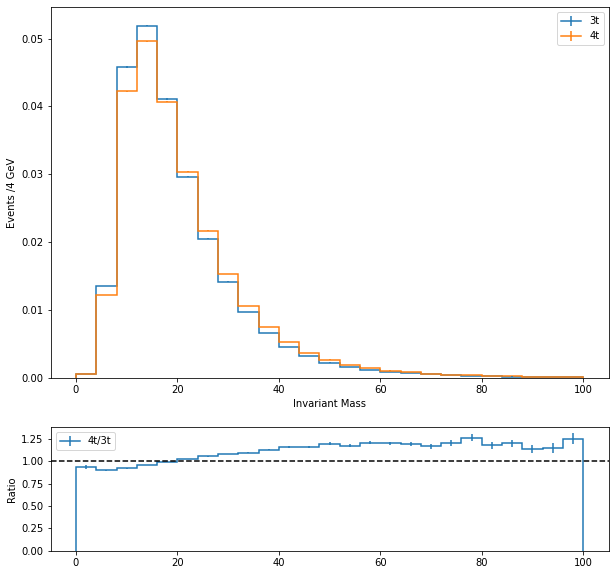

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([invariant_mass_jets_3t,invariant_mass_jets_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1],set_range=(0,100))
ax[0].set_xlabel(r'Invariant Mass')
plt.show()

### Boost

In [12]:
tops_3t_padded = ak.pad_none(tops_3t,3,axis=1)
print(ak.num(tops_3t_padded))
tops_3t_broadcasted = ak.fill_none(tops_3t_padded,tops_3t)
print(tops_3t_broadcasted)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[{rho: 164, phi: -2.65, eta: -0.969, t: 310}, [...], [[{...}], ...]], ...]


In [13]:
print(ak.num(matched_jets_3t))  # Check the size of jets_3t
print(len(ak.num(tops_3t_broadcasted[0,1])))  # Check the size of tops_3t_broadcasted
print(tops_3t_broadcasted[0,1])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
1063745
[[{rho: 164, phi: -2.65, eta: -0.969, t: 310}], [{...}], ..., [{rho: 145, ...}]]
